In [1]:
!git clone https://github.com/rajeevratan84/image-segmentation-keras.git

Cloning into 'image-segmentation-keras'...
remote: Enumerating objects: 1165, done.
remote: Total 1165 (delta 0), reused 0 (delta 0), pack-reused 1165 (from 1)
Receiving objects: 100% (1165/1165), 3.29 MiB | 36.21 MiB/s, done.
Resolving deltas: 100% (752/752), done.


In [2]:
%cd image-segmentation-keras

/kaggle/working/image-segmentation-keras


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from keras.callbacks import ModelCheckpoint
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from keras_segmentation.models.unet import resnet50_unet
from tensorflow.keras.optimizers import Adam
import time

In [5]:
image_train_list = os.listdir('/kaggle/input/beach-litter-dataset/Beachlitter_prepped/train_images')
anns_train_list = os.listdir('/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/train_masks_grayscale')
image_val_list = os.listdir('/kaggle/input/beach-litter-dataset/Beachlitter_prepped/val_images')
anns_val_list = os.listdir('/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/val_masks_grayscale')

image_train_list = [substring[:6] for substring in image_train_list]
anns_train_list = [substring[:6] for substring in anns_train_list]
image_val_list = [substring[:6] for substring in image_val_list]
anns_val_list = [substring[:6] for substring in anns_val_list]

print('number of train data pairs: ', len(set(image_train_list).intersection(anns_train_list)))
print('number of validation data pairs: ', len(set(image_val_list).intersection(anns_val_list)))
del image_train_list, anns_train_list, image_val_list, anns_val_list

number of train data pairs:  2240
number of validation data pairs:  560


In [6]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice Loss between the ground truth and predictions.

    Parameters:
    - y_true: Ground truth labels (shape: [batch_size, height, width, num_classes])
    - y_pred: Predicted labels (shape: [batch_size, height, width, num_classes])
    - smooth: Smoothing factor to avoid division by zero

    Returns:
    - Dice Loss value
    """
    # Flatten the tensors
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice

In [14]:
model = resnet50_unet(n_classes=8, input_height=544, input_width=736)

In [15]:
# https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

In [16]:
# def custom_augmentation():
#     return iaa.Sequential(
#         [
#             # apply the following augmenters to most images
# #             iaa.GaussianBlur(sigma=(0.0, 0.5)),
#             iaa.Fliplr(0.5), # horizontally flip 50% of all images
#             iaa.GammaContrast((0.5, 2.0)),
#             iaa.convolutional.Sharpen(alpha=(0.0, 0.2), lightness=(0.8, 1.2)),
# #             iaa.Grayscale(alpha=(0.0, 1.0)),
# #             iaa.pillike.FilterFindEdges(),
# #             iaa.ShearX((-20, 20)),
# #             iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
# #             iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),
#         ])
# # [sharpness, contrast], blur (jgn terlalu blur), saturation, hue

# def image_preprocessing(image):
#     image = tf.cast(image, tf.float32)
#     scaled_image = image.numpy() / 255.0
#     return scaled_image

In [17]:
from keras_segmentation.data_utils.data_loader import image_segmentation_generator, verify_segmentation_dataset
train_gen = image_segmentation_generator(images_path = "/kaggle/input/beach-litter-dataset/Beachlitter_prepped/train_images", 
                                         segs_path = "/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/train_masks_grayscale",  
                                         batch_size = 2,  
                                         n_classes = 8,
                                         input_height = 544, 
                                         input_width = 736, 
                                         output_height = model.output_height, 
                                         output_width = model.output_width,
                                         do_augment=False, 
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                         read_image_type=1)

val_gen = image_segmentation_generator(images_path = "/kaggle/input/beach-litter-dataset/Beachlitter_prepped/val_images", 
                                       segs_path = "/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/val_masks_grayscale",  
                                       batch_size = 2,
                                       n_classes = 8, 
                                       input_height = 544, 
                                       input_width = 736, 
                                       output_height = model.output_height, 
                                       output_width = model.output_width,
                                       do_augment = False,
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                       read_image_type=1)

In [18]:
verify_segmentation_dataset(images_path = "/kaggle/input/beach-litter-dataset/Beachlitter_prepped/train_images",
                            segs_path = "/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/train_masks_grayscale",
                            n_classes = 8)
verify_segmentation_dataset(images_path = "/kaggle/input/beach-litter-dataset/Beachlitter_prepped/val_images",
                            segs_path = "/kaggle/input/beach-litter-dataset/Beachlitter_masks_update/val_masks_grayscale",
                            n_classes = 8)

100%|██████████| 2240/2240 [00:25<00:00, 87.05it/s] 


Dataset verified! 


100%|██████████| 560/560 [00:05<00:00, 94.22it/s] 

Dataset verified! 


True

In [19]:
checkpoint_path = "/kaggle/working/weights/resnet50_unet.weights.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok = True)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor="val_dice_loss",
                             save_best_only=True,
                             save_weights_only = True,
                             mode="min")

In [20]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss= 'categorical_crossentropy',#dice_loss,
    metrics=[dice_loss, 'accuracy']#, tf.keras.metrics.F1Score(average = "weighted")] # f1-score, accuracy
)

start_time = time.time()
model.fit(train_gen,
          steps_per_epoch = 512,
          validation_data=val_gen,
          validation_steps=512,
          epochs = 10, # coba 20 epoch u/ cek overfitting
          callbacks=[checkpoint],
          initial_epoch=0)
print('training completed in {} s'.format(time.time()-start_time))

Epoch 1/10


I0000 00:00:1725186282.311880     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 20 bytes spill stores, 20 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 229s 323ms/step - accuracy: 0.5978 - dice_loss: 0.5645 - loss: 1.3243 - val_accuracy: 0.8709 - val_dice_loss: 0.1949 - val_loss: 0.4257
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 167s 327ms/step - accuracy: 0.8192 - dice_loss: 0.2737 - loss: 0.6079 - val_accuracy: 0.8309 - val_dice_loss: 0.2489 - val_loss: 0.5792
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 169s 331ms/step - accuracy: 0.8277 - dice_loss: 0.2594 - loss: 0.5639 - val_accuracy: 0.8711 - val_dice_loss: 0.1636 - val_loss: 0.4208
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 168s 329ms/step - accuracy: 0.8735 - dice_loss: 0.1907 - loss: 0.3991 - val_accuracy: 0.8770 - val_dice_loss: 0.1644 - val_loss: 0.3652
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 169s 330ms/step - accuracy: 0.8639 - dice_loss: 0.2025 - loss: 0.4218 - val_accuracy: 0.8911 - val_dice_loss: 0.1476 - val_loss: 0.3314
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 169s 330ms/step - accuracy: 0.8922 - dice_loss: 0.1620 - loss: 0.3297 - val_accuracy: 0.886

In [21]:
print(model.history.history.keys())

dict_keys(['accuracy', 'dice_loss', 'loss', 'val_accuracy', 'val_dice_loss', 'val_loss'])


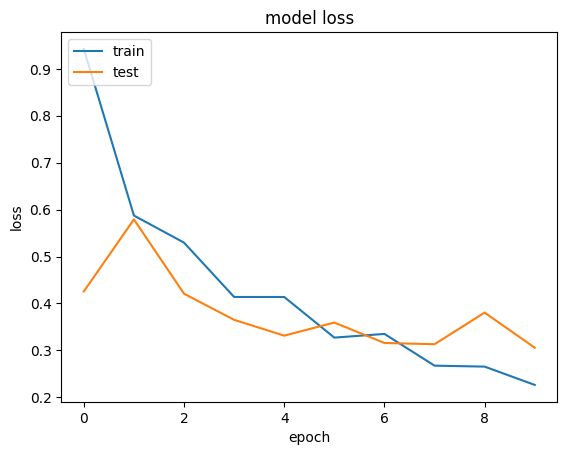

In [22]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

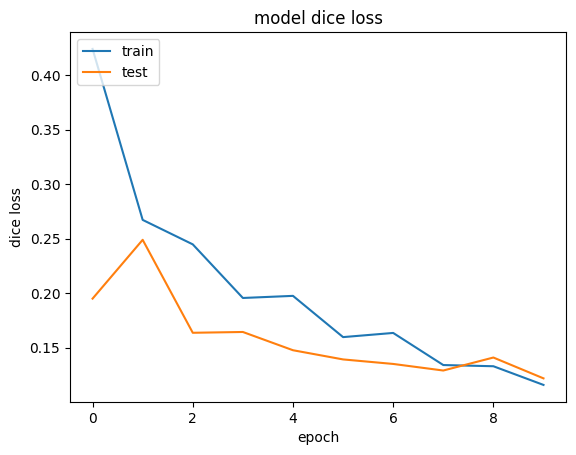

In [23]:
plt.plot(model.history.history['dice_loss'])
plt.plot(model.history.history['val_dice_loss'])
plt.title('model dice loss')
plt.ylabel('dice loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

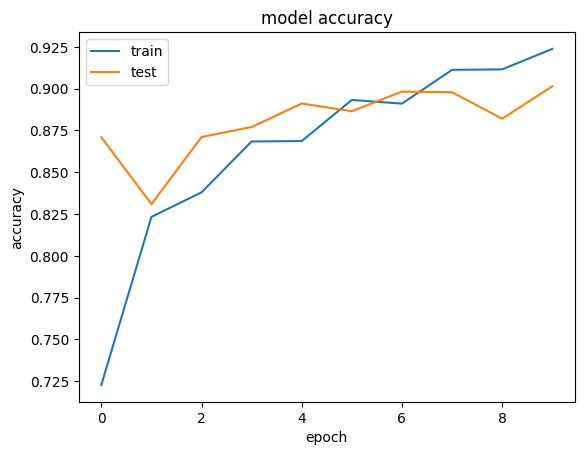

In [24]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


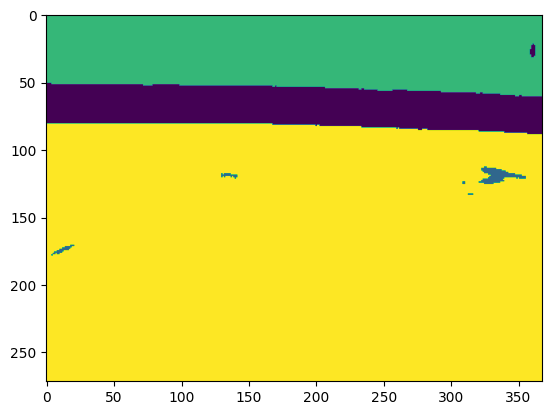

In [33]:
out = model.predict_segmentation(
    inp = "/kaggle/input/beach-litter-dataset/Beachlitter_prepped/test_images/002800.jpg",
    colors = [
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0]]
)
plt.imshow(out)

In [41]:
from IPython.display import Image

o4 = model.predict_segmentation(
    inp="/kaggle/input/beach-litter-dataset/Beachlitter_prepped/test_images/002857.jpg",
    out_fname="/kaggle/working/out4.png",
    overlay_img=False,
    show_legends=True,
    class_names = ["Artificial Litter", "Background", "Living", "Sea", "Natural litter", "Sky", "Sand Beach", "Non-Living"],
    colors = [
    [0, 0, 128],
    [0, 128, 0],
    [0, 128, 128],
    [128, 0, 0],
    [128, 0, 128],
    [128, 128, 0],
    [128, 128, 128],
    [0, 0, 64]]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


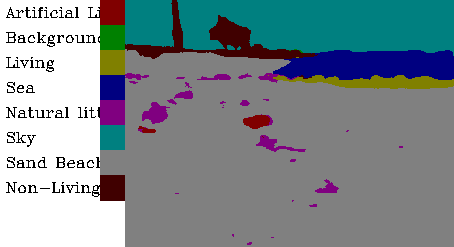

In [43]:
Image("/kaggle/working/out4.png")